# Model Training

## Guide

In [1]:
guide_used = "https://towardsdatascience.com/atom-a-python-package-for-fast-exploration-of-machine-learning-pipelines-653956a16e7b"

## Make necessary imports

In [2]:
import opendatasets as od
import pandas as pd
import numpy as np
import tqdm
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import linear_model, naive_bayes, ensemble, tree, svm, model_selection, preprocessing, feature_extraction, metrics, base, pipeline
from joblib import dump, load

## Importing data

### Import data

In [3]:
od.download("https://www.kaggle.com/datasets/purusinghvi/email-spam-classification-dataset")

Skipping, found downloaded files in ".\email-spam-classification-dataset" (use force=True to force download)


### Read data

In [4]:
file = 'email-spam-classification-dataset/combined_data.csv'
df = pd.read_csv(file)

## Visualizing data

### Dataset statistics

In [5]:
labels = {0: 'Ham', 1: 'Spam'}

label_counts = df["label"].value_counts()
number_of_ham = label_counts[0]
number_of_spam = label_counts[1]
average_length_of_ham = df[df['label'] == 0]['text'].str.len().mean()
average_length_of_spam = df[df['label'] == 1]['text'].str.len().mean()

print(f'Number of ham (0) messages: {number_of_ham}')
print(f'Number of spam (1) messages: {number_of_spam}')
print()
print(f'Average character length of ham (0) messages: {round(average_length_of_ham)}')
print(f'Average character length of spam (1) messages: {round(average_length_of_spam)}')

Number of ham (0) messages: 39538
Number of spam (1) messages: 43910

Average character length of ham (0) messages: 2122
Average character length of spam (1) messages: 1250


### Visualize table

In [6]:
df.head()

,label,text
0,1,ounce feather bowl hummingbird opec moment ala...
1,1,wulvob get your medircations online qnb ikud v...
2,0,computer connection from cnn com wednesday es...
3,1,university degree obtain a prosperous future m...
4,0,thanks for all your answers guys i know i shou...


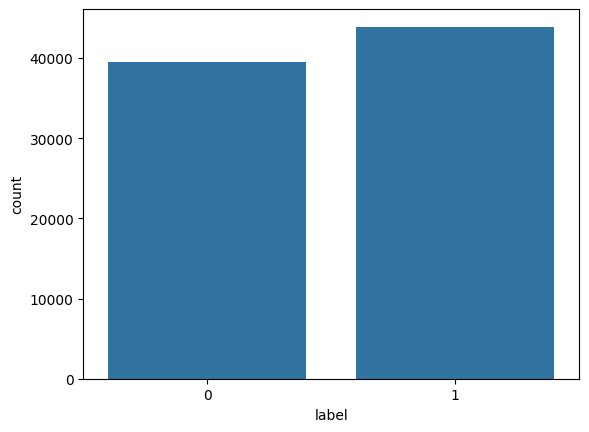

In [7]:
sns.countplot(x = 'label', data = df)
plt.show()

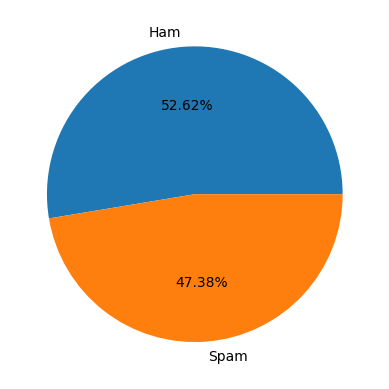

In [8]:
plt.pie(label_counts, labels = labels.values(), autopct = "%.2f%%")
plt.show()

In [9]:
df.groupby(df['label']).describe()

text                                                               
       count unique                                                top freq
label                                                                      
0      39538  39538   computer connection from cnn com wednesday es...    1
1      43910  43910  ounce feather bowl hummingbird opec moment ala...    1

## Data preprocessing

### Data cleaning

In [11]:
# Check for null values
print(f'Number of null values: {df["text"].isna().sum()}')

# Handle duplicates
print(f'Number of duplicated urls : {np.sum(df.duplicated())}')
df.drop_duplicates(inplace = True)
print(f'Number of duplicated urls (after dropping duplicates) : {np.sum(df.duplicated())}')

Number of null values: 0
Number of duplicated urls : 0
Number of duplicated urls (after dropping duplicates) : 0


### Data preparation

In [12]:
# Define X and y
X = df.drop('label', axis = 1).values
y = df['label'].values
print(X.shape, y.shape)

# Converting text into features -> Count of each word in the url
vectorizer = feature_extraction.text.CountVectorizer()
X = vectorizer.fit_transform(X.reshape(-1))                                         # Leave X as sparse matrix, don't convert it to dense matrix (memory limitations)
print("Total number of features :", len(vectorizer.get_feature_names_out()))
print(X.shape)

(83448, 1) (83448,)
Total number of features : 310813
(83448, 310813)


### Split data into training/test set

In [13]:
# Splitting the data into training and testing data (85/15) -> Stratification
X_train, X_test, y_train, y_test = model_selection.train_test_split(X, y, test_size = 0.15, stratify = y)
print(X_train.shape, X_test.shape)

(70930, 310813) (12518, 310813)


### Check label distribution in training and test set

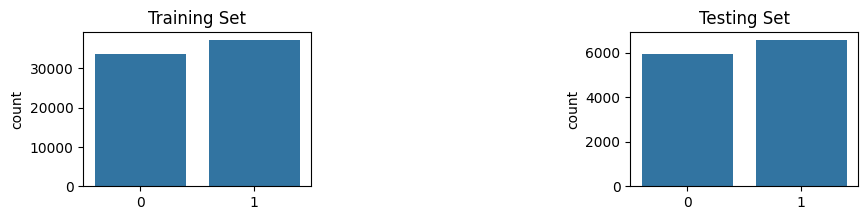

In [14]:
# Bar charts
plt.figure(figsize = (10, 2))

plt.subplot(1, 3, 1)
plt.title("Training Set")
sns.countplot(x = y_train)

plt.subplot(1, 3, 3)
plt.title("Testing Set")
sns.countplot(x = y_test)
plt.show()

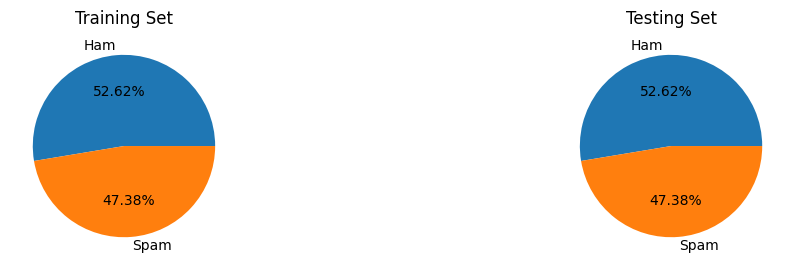

In [15]:
# Pie charts
plt.figure(figsize = (10, 3))

plt.subplot(1, 3, 1)
plt.title("Training Set")
plt.pie(pd.Series(y_test).value_counts(), labels = labels.values(), autopct = "%.2f%%")

plt.subplot(1, 3, 3)
plt.title("Testing Set")
plt.pie(pd.Series(y_test).value_counts(), labels = labels.values(), autopct = "%.2f%%")
plt.show()

## Setting up model

### Defining model and hyperparameters

In [17]:
# log_reg = linear_model.LogisticRegression(max_iter = 1000)
# svc = svm.LinearSVC()
# nb = naive_bayes.MultinomialNB()
# desc_tree = tree.DecisionTreeClassifier()
rf = ensemble.RandomForestClassifier()

models = [rf]
scores = []

### Model setup

## Training the model

### Help methods

In [20]:
def evaluate(model):
    cross_val_scores = model_selection.cross_val_score(base.clone(model), X_train[:5000], y_train[:5000], cv = 5)
    print(f"\nCross Validation Scores for model {model} : ")
    print(cross_val_scores, cross_val_scores.mean())
    scores.append(cross_val_scores.mean())

### Evaluate models

In [21]:
for model in models:
    evaluate(model)


Cross Validation Scores for model RandomForestClassifier() : 
[0.968 0.951 0.953 0.954 0.97 ] 0.9591999999999998


### Training model

In [22]:
model = models[np.argmax(scores)]
print(f"Best Model : {model}")

model.fit(X_train[:5000], y_train[:5000])

Best Model : RandomForestClassifier()


RandomForestClassifier()

### Make predictions

In [23]:
# Training set
y_train_pred = model.predict(X_train)

# Validation set
y_test_pred = model.predict(X_test)

## Visualize model results

### Calculate model results

Accuracy (Train) :  0.9628647962780206
[[32126  1481]
 [ 1153 36170]]


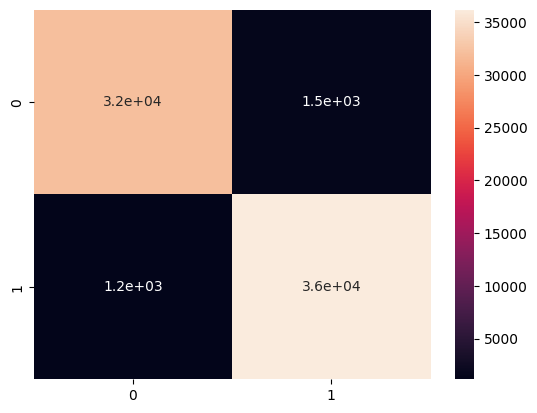

              precision    recall  f1-score   support

           0       0.97      0.96      0.96     33607
           1       0.96      0.97      0.96     37323

    accuracy                           0.96     70930
   macro avg       0.96      0.96      0.96     70930
weighted avg       0.96      0.96      0.96     70930



In [24]:
# Training set
accuracy_train = np.sum(y_train == y_train_pred) / len(y_train)
print("Accuracy (Train) : ", accuracy_train)

# Confusion Matrix
cm_train = metrics.confusion_matrix(y_train, y_train_pred)
print(cm_train)

# Heatmap
sns.heatmap(cm_train, annot = True)
plt.show()

# Classification Report
clf_report = metrics.classification_report(y_train, y_train_pred)
print(clf_report)

Accuracy (Test) :  0.9612557916600096
[[5661  270]
 [ 215 6372]]


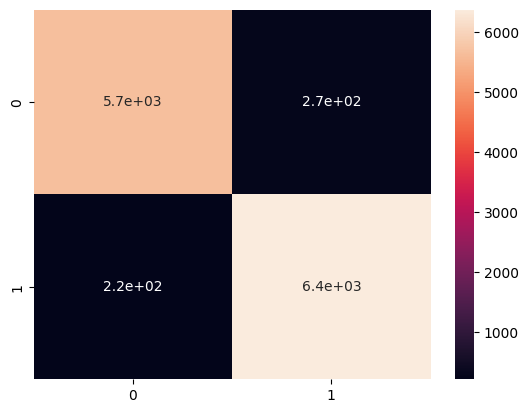

              precision    recall  f1-score   support

           0       0.96      0.95      0.96      5931
           1       0.96      0.97      0.96      6587

    accuracy                           0.96     12518
   macro avg       0.96      0.96      0.96     12518
weighted avg       0.96      0.96      0.96     12518



In [25]:
# Validation set
accuracy_test = np.sum(y_test == y_test_pred) / len(y_test)
print("Accuracy (Test) : ", accuracy_test)

# Confusion Matrix
cm_test = metrics.confusion_matrix(y_test, y_test_pred)
print(cm_test)

# Heatmap
sns.heatmap(cm_test, annot = True)
plt.show()

# Classification Report
clf_report = metrics.classification_report(y_test, y_test_pred)
print(clf_report)

### Graph model results

### Store model results

In [26]:
dump(model, "models/classification/random_forest_model_000.h5")

['models/classification/random_forest_model_000.h5']

### Loading saved model

#### Loading the model

In [27]:
saved_model = load("models/classification/random_forest_model_000.h5")

#### Make predictions

In [28]:
inp = np.array(["loading the model and making predictions",
       "you won a lottery !", "Nothing is permanant",
        "hello, want a job ?"])

vectorized_inp = vectorizer.transform(inp)
print(vectorized_inp.shape)
saved_model.predict(vectorized_inp)

(4, 310813)


array([1, 1, 1, 1], dtype=int64)